## Import Module

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import SQLContext
from pyspark import SparkContext

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Data Pre-processing

In [2]:
## 1. Read dataset

### links.csv

In [16]:
# df_pre_links = pd.read_csv('links.csv')
spark = SparkSession \
    .builder \
    .appName("Individual Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# df_pre_links = spark.read.csv("hdfs://namenode/projectDB/links.csv")
df_pre_links = spark.read.option("delimiter", ",").option("header", True).csv("hdfs://namenode/projectDB/links.csv")

print(df_pre_links.info())  
print(df_pre_links.describe())
df_pre_links.isnull().any(axis=0)

IllegalArgumentException: java.net.UnknownHostException: namenode

#### Missing Value
The field "tmdbId" contains missing value.

tmdbId is an identifier for movies used by https://www.themoviedb.org: it can not use imputation, instead, use removal.

In [4]:
df_pre_links_delete = df_pre_links.dropna()
print(df_pre_links_delete.info())
# see the dataset contains missing value or not after the removal
df_pre_links_delete.isnull().any(axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9734 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9734 non-null   int64  
 1   imdbId   9734 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 304.2 KB
None


movieId    False
imdbId     False
tmdbId     False
dtype: bool

#### Cause links.csv only stores the relation between ids, it do not have noise or outlier 

### movies.csv

In [5]:
df_pre_movies = pd.read_csv('movies.csv')
print(df_pre_movies.info())  # get an initial overview of the dataset.
print(df_pre_movies.describe())
df_pre_movies.isnull().any(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


movieId    False
title      False
genres     False
dtype: bool

### ratings.csv

In [6]:
df_pre_rating = pd.read_csv('ratings.csv')
print(df_pre_rating.info())  
df_pre_rating.isnull().any(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

### tags.csv

In [7]:
df_pre_tags = pd.read_csv('tags.csv')
print(df_pre_tags.info())  # get an initial overview of the dataset.
print(df_pre_tags.describe())
df_pre_tags.isnull().any(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None
            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09


userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

## 2. Merge data table ratings.csv and movies.csv for further analysis

In [8]:
# merging data tables
df = pd.merge(df_pre_rating,df_pre_movies,on='movieId')

# drop field 'timestamp'
df= df.drop(['timestamp'], axis=1)
df

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


In [9]:
#get numerical column
numCol  = [col for col in df.columns if  df[col].dtype != "O"]
numCol

['userId', 'movieId', 'rating']

In [10]:
#get categorical column
catColumn  = [col for col in df.columns if  df[col].dtype == "O"]
catColumn

['title', 'genres']

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,326.127564,182.618491,1.0,177.0,325.0,477.0,610.0
movieId,100836.0,19435.295718,35530.987199,1.0,1199.0,2991.0,8122.0,193609.0
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0


## 3. dataset statistic

In [12]:
#check duplicate data 
print("Contain duplicate Data: " + str(df.duplicated().all()))

Contain duplicate Data: False


In [13]:
# check missing Value
df.isnull().sum().sort_values(ascending=False)

genres     0
title      0
rating     0
movieId    0
userId     0
dtype: int64

<AxesSubplot:>

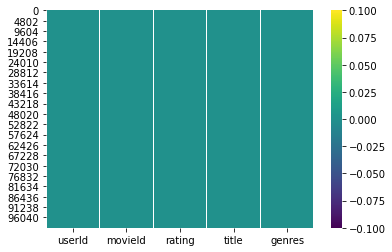

In [14]:
cols =df.columns
sns.heatmap(df[cols].isnull(), cmap='viridis')

In [15]:
df.shape

(100836, 5)

### From the statistic of dataset, the following information can be concluded:
- Frist dataset consists of 100003 rows and 4 columns.

- Second The dataset consists of 1682 rows and 2columns.

- There is Null data through 1 column and need to drop it.

- No duplicate data in dataset.


## 4. Data analysis


In [16]:
### Histplot for neumerical data

In [17]:

def numerical_plotting(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0])
    ax[0].set(yticks=[])
    sns.histplot(df[col],kde=True)
    plt.xticks(rotation=45)
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(df[col].mode()[0]) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()   

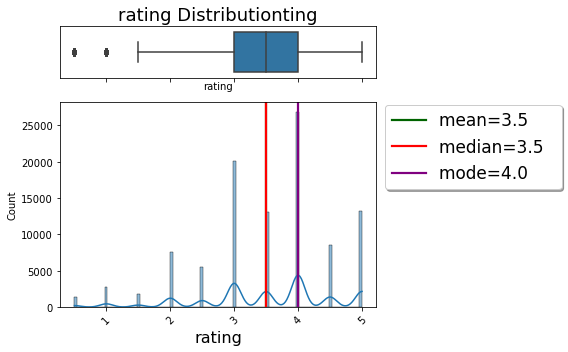

In [18]:
numerical_plotting(df,'rating','rating Distributionting','  ')

In [19]:
df.describe()[['rating']].T

,count,mean,std,min,25%,50%,75%,max
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0


### Histogram

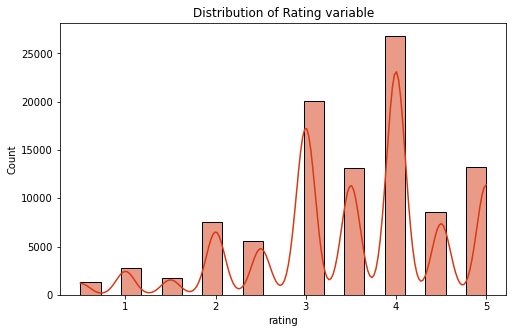

In [20]:
plt.figure(figsize=(8,5))
sns.histplot( x = df["rating"], bins = 20, kde = True, color = "#D63913").set(title = "Distribution of Rating variable");

### From the analysist of dataset, the following can be concluded:
- Data is not Normaly Distributed
- Skeynees detected (left & right)

# Big Data Queries by SparkSQL

## 1. Creating DataFrames

In [10]:
spark = SparkSession \
    .builder \
    .appName("Individual Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [11]:
# sc = spark.sparkContext
# path = 'hdfs://34.151.108.114:8080/projectDB/links.csv'
# df = spark.read.csv(path)
# df.show()

In [12]:
# df_links = spark.read.csv("links.csv")
df_links = spark.read.option("delimiter", ",").option("header", True).csv("links.csv")
df_links.show(5)
df_links.printSchema()

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

root
 |-- movieId: string (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: string (nullable = true)



In [13]:
df_movies = spark.read.option("delimiter", ",").option("header", True).csv("movies.csv")
df_movies.show(5)
df_movies.printSchema()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [25]:
df_ratings = spark.read.option("delimiter", ",").option("header", True).csv("ratings.csv")
df_ratings.show(5)
df_ratings.printSchema()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [26]:
df_tags = spark.read.option("delimiter", ",").option("header", True).csv("tags.csv")
df_tags.show(5)
df_tags.printSchema()

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: string (nullable = true)



## 1. Big Data Queries by SparkSQL

In [27]:
df_tags.createOrReplaceTempView("tags")
df_links.createOrReplaceTempView("links")
df_movies.createOrReplaceTempView("movies")
df_ratings.createOrReplaceTempView("ratings")


sqlDF= spark.sql("SELECT Movies.title, Movies.genres,tags.tag FROM tags JOIN movies ON tags.movieId=movies.movieId")
sqlDF.show()

+--------------------+--------------------+----------------+
|               title|              genres|             tag|
+--------------------+--------------------+----------------+
|    Toy Story (1995)|Adventure|Animati...|             fun|
|    Toy Story (1995)|Adventure|Animati...|           pixar|
|    Toy Story (1995)|Adventure|Animati...|           pixar|
|      Jumanji (1995)|Adventure|Childre...|            game|
|      Jumanji (1995)|Adventure|Childre...|  Robin Williams|
|      Jumanji (1995)|Adventure|Childre...|magic board game|
|      Jumanji (1995)|Adventure|Childre...|         fantasy|
|Grumpier Old Men ...|      Comedy|Romance|             old|
|Grumpier Old Men ...|      Comedy|Romance|           moldy|
|Father of the Bri...|              Comedy|          remake|
|Father of the Bri...|              Comedy|       pregnancy|
|      Sabrina (1995)|      Comedy|Romance|          remake|
|American Presiden...|Comedy|Drama|Romance|       president|
|American Presiden...|Co